In [1]:
import graph_tool.all as gt
import pandas as pd
import numpy as np
import scipy as sc

In [2]:
#generate network
g = gt.collection.data["polblogs"]
g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
g = gt.Graph(g, prune=True)
g

<Graph object, directed, with 793 vertices and 15841 edges, 4 internal vertex properties, 2 internal graph properties, at 0x7fc8bc5b8c70>

In [3]:
#get blockmodel
state = gt.minimize_blockmodel_dl(g)


In [4]:
#extract blockmodel membership
unos_datos = state.b.a
df = pd.DataFrame(data=unos_datos, columns = ["comunidades"])
df.head()


,comunidades
0,0
1,0
2,1
3,1
4,0


In [5]:
#count blockmodel members
my_tally = df.value_counts(sort=False).rename("N").reset_index()


In [6]:
#scale down
my_tally["redondeado"] = np.ceil(my_tally["N"] * 0.1)
my_tally


,comunidades,N,redondeado
0,0,171,18.0
1,1,136,14.0
2,2,35,4.0
3,3,41,5.0
4,4,74,8.0
5,5,130,13.0
6,6,26,3.0
7,7,69,7.0
8,8,87,9.0
9,9,24,3.0


In [12]:
#make empty array to fill with nodes members of block
my_array = []


In [13]:
#fill array
for i, j in zip(my_tally.comunidades, my_tally.redondeado.astype(int)):  
    my_array.extend([i] * j)


In [14]:
#get the block adjacency matrix
my_adj = gt.adjacency(state.get_bg(), state.get_ers()).T


In [15]:
#escalar esta matriz para que tenga el numero de enlaces escalados
n = len(my_tally.N)
matrix_enlaces_totales = np.zeros((n,n)) # Pre-allocate matrix

for r in range(0,n):
    for s in range(0,n):
        matrix_enlaces_totales[r,s] = (my_tally.N[r] * my_tally.N[s])


In [16]:
#sacar la fraccion de enlaces reales
matrix_fraccion = np.zeros((n,n)) # Pre-allocate matrix

for r in range(0,n):
    for s in range(0,n):
        matrix_fraccion[r,s] = my_adj.toarray()[r,s] / matrix_enlaces_totales[r,s]


In [17]:
#escalar la matriz propiamente
matrix_escalado = np.zeros((n,n)) # Pre-allocate matrix

for r in range(0,n):
    for s in range(0,n):
        matrix_escalado[r,s] = np.ceil(matrix_fraccion[r,s] * (my_tally.redondeado[r] * my_tally.redondeado[r]))

In [18]:
#generar nueva red, escalada
u = gt.generate_sbm(b= my_array, probs = matrix_escalado)

In [19]:
u

<Graph object, undirected, with 84 vertices and 227 edges, at 0x7fc7cf7f2c70>

In [20]:
#sacar el nuevo modelo de bloques
state_u  = gt.minimize_blockmodel_dl(u)

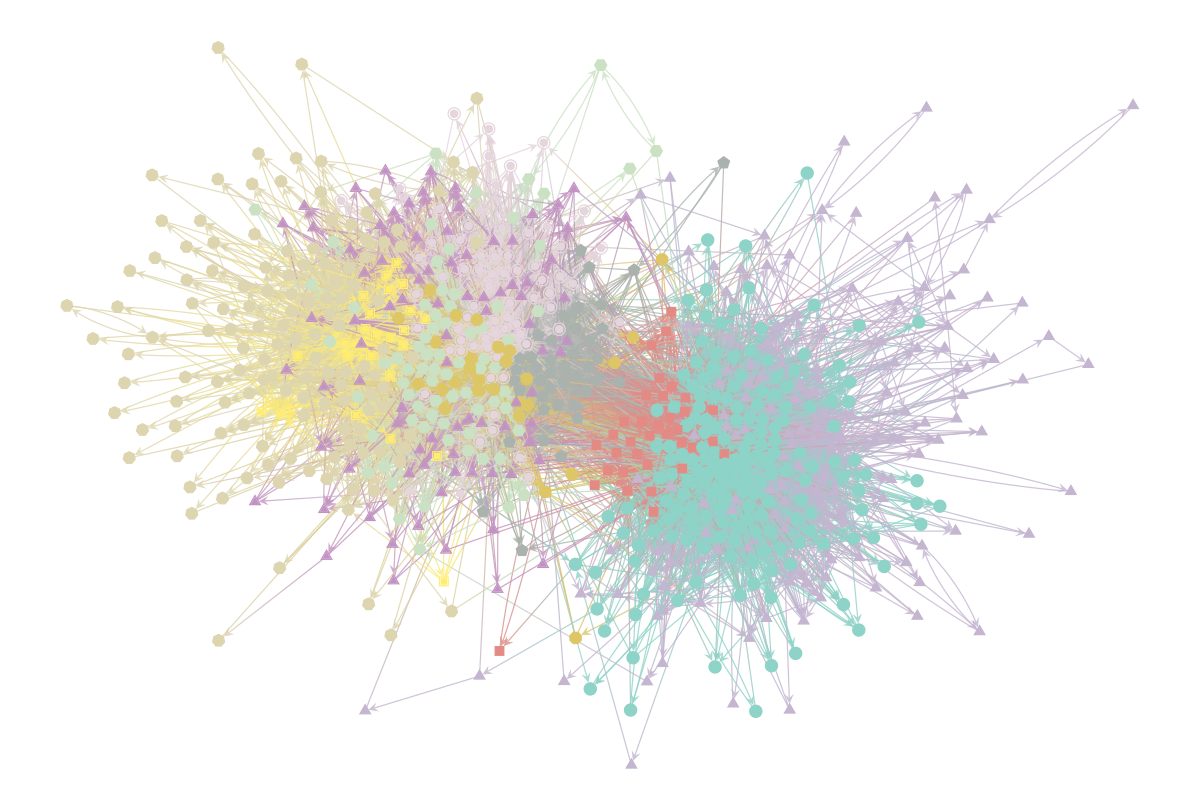

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc8bc5b8c70, at 0x7fc7cf7bf8e0>

In [21]:
#big nw structure
state.draw(pos=g.vp["pos"], vertex_shape=state.get_blocks()

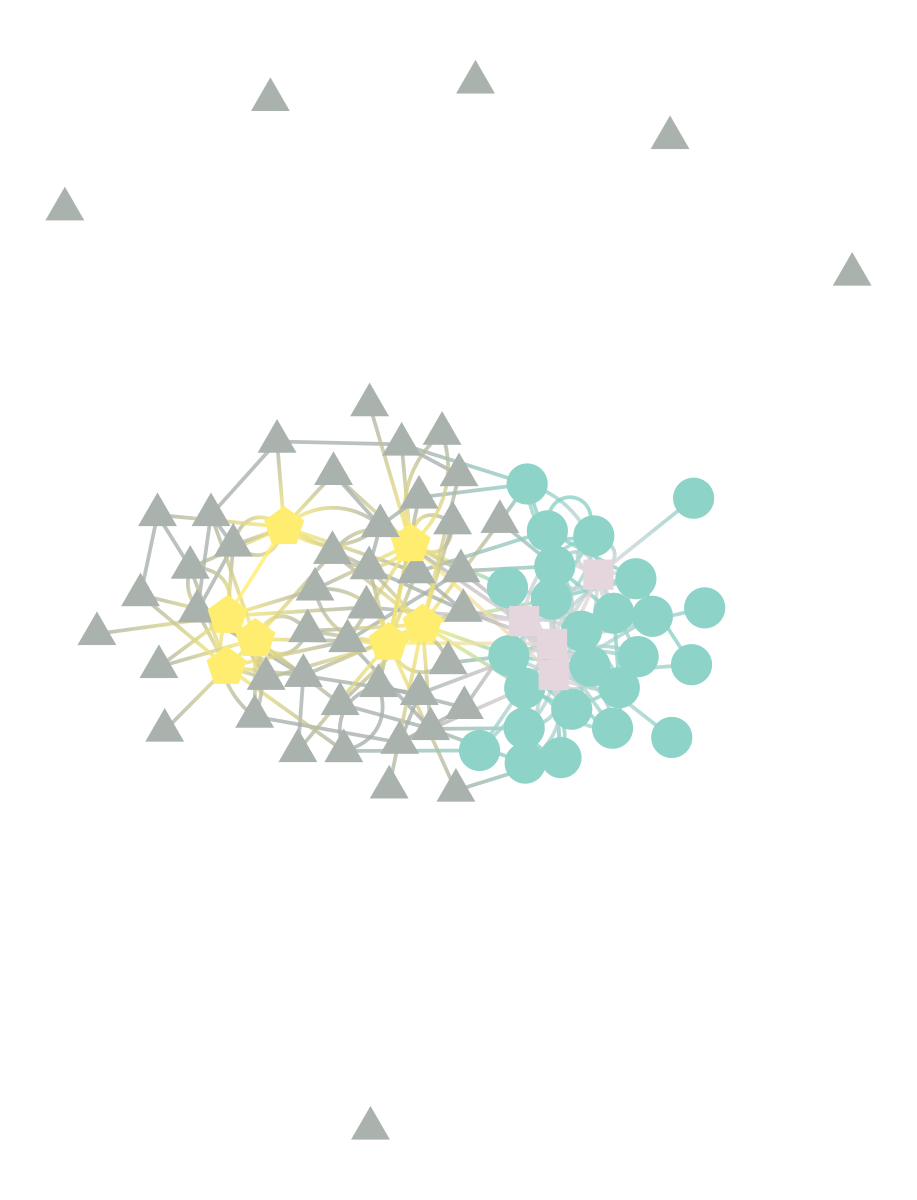

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc7cf7f2c70, at 0x7fc7cf7ea2e0>

In [24]:
#small nw structure
state_u.draw(vertex_shape=state_u.get_blocks())

In [48]:
hist_u = gt.vertex_hist(u, "total")
hist_g = gt.vertex_hist(g, "total")

In [49]:
len(hist_g[1])

416

In [50]:
u_df = pd.DataFrame({"x" : hist_u[1][:32], 
                     "y" : hist_u[0]}
                   )

g_df = pd.DataFrame({"x" : hist_g[1][:415], 
                     "y" : hist_g[0]}
                   )


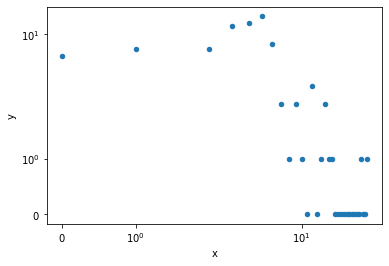

In [47]:
u_df.plot(kind="scatter", x="x", y="y", loglog="sym")

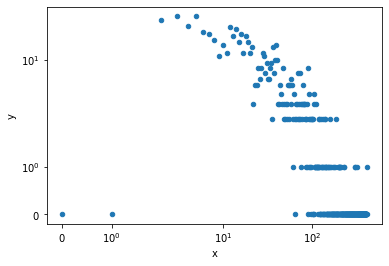

In [51]:
g_df.plot(kind="scatter", x="x", y="y", loglog="sym")